In [1]:
from core import Container, Node, node
import pandas as pd

### Data Container
Create a class to hold a dataframe an a helper function to load hdf5 files

In [2]:
class DataFrameContainer(Container):
    def __init__(self, df: pd.DataFrame):
        self.df = df
    
    @classmethod
    def from_hdf5(cls, path: str, key: str):
        df = pd.read_hdf(path, key=key, mode='r')
        return cls(df)

## Simple example of a processing node.
The first argument **must** be the container\
the process method **must** always return a container instance.

In [3]:
class Splice(Node):        
    def process(self, container, data_column, start, stop):
        container.df['spliced'] = container.df[data_column].apply(lambda a: a[start:stop])
        return container

Create a container from a pandas dataframe stored as an HDF5 file

In [4]:
cont = DataFrameContainer.from_hdf5('./data.h5', key='data')

Write the pipeline and that's it!

In [5]:
cont >> Splice(start=10, stop=1000, data_column='_RAW_CURVE') >> Splice('spliced', 50, 500)

It works

In [6]:
cont.df.spliced.iloc[0].shape

(450,)

## Even simpler example!
You can also just use the @node decorator if it's just a simple function\
The aforementioned class example can be useful if the processing is more complex

In [7]:
@node
def splice(container, data_column, start, stop):
    container.df['spliced'] = container.df[data_column].apply(lambda a: a[start:stop])
    return container

In [8]:
cont = DataFrameContainer.from_hdf5('./data.h5', key='data')

In [9]:
cont >> splice(start=10, stop=500, data_column='_RAW_CURVE') >> splice('spliced', 50, 80)

Just to show that this also works

In [10]:
cont.df.iloc[0].spliced.size

30

# More complex example

In [11]:
import numpy as np
from scipy import fftpack
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

## More complex nodes are basically simple wrapper functions

In [12]:
@node
def normalize(container, data_column):
    func = lambda a: ((a - np.min(a)) / (np.max(a - np.min(a))))
    container.df['normalize'] = container.df[data_column].apply(func)
    return container


@node
def log(container, data_column):
    container.df['log'] = container.df[data_column].apply(lambda x: np.log10(x))
    return container
    

@node
def absval(container, data_column):
    container.df['absval'] = container.df[data_column].apply(lambda x: np.abs(x))
    return container

@node
def rfft(container, data_column):
    data = np.vstack(container.df[data_column].values)

    container.df['fft'] = fftpack.rfft(data).tolist()
    container.df['fft'] = container.df['fft'].apply(np.array)

    return container


@node
def LDA(container, data_column, labels_column, n_components):
    X = np.vstack(container.df[data_column].values)
    y = container.df[labels_column]
    
    lda = LinearDiscriminantAnalysis(n_components=n_components)
    
    X_ = lda.fit_transform(X, y)
    
    container.df['lda_transform'] = X_.tolist()
    container.df['lda_transform'] = container.df['lda_transform'].apply(np.array)
    
    return container


In [13]:
cont = DataFrameContainer.from_hdf5('./data.h5', key='data')

### More complex pipeline

In [14]:
cont \
>> splice('_RAW_CURVE', 0, 2990)\
>> normalize('spliced')\
>> rfft('normalize')\
>> absval('fft')\
>> log('absval')\
>> splice('log', 0, 1000)\
>> LDA('spliced', 'FCLUSTER_LABELS', 2)

/home/kushal/python-virtual-environments/mesmerize/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [15]:
from matplotlib import pyplot as plt

### View the LDA projection

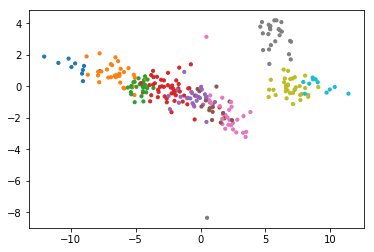

In [16]:
data = np.vstack(cont.df.lda_transform.values)
plt.scatter(data[:, 0], data[:, 1], c=cont.df.FCLUSTER_LABELS, cmap='tab10', s=10)